In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from sklearn.linear_model import LinearRegression

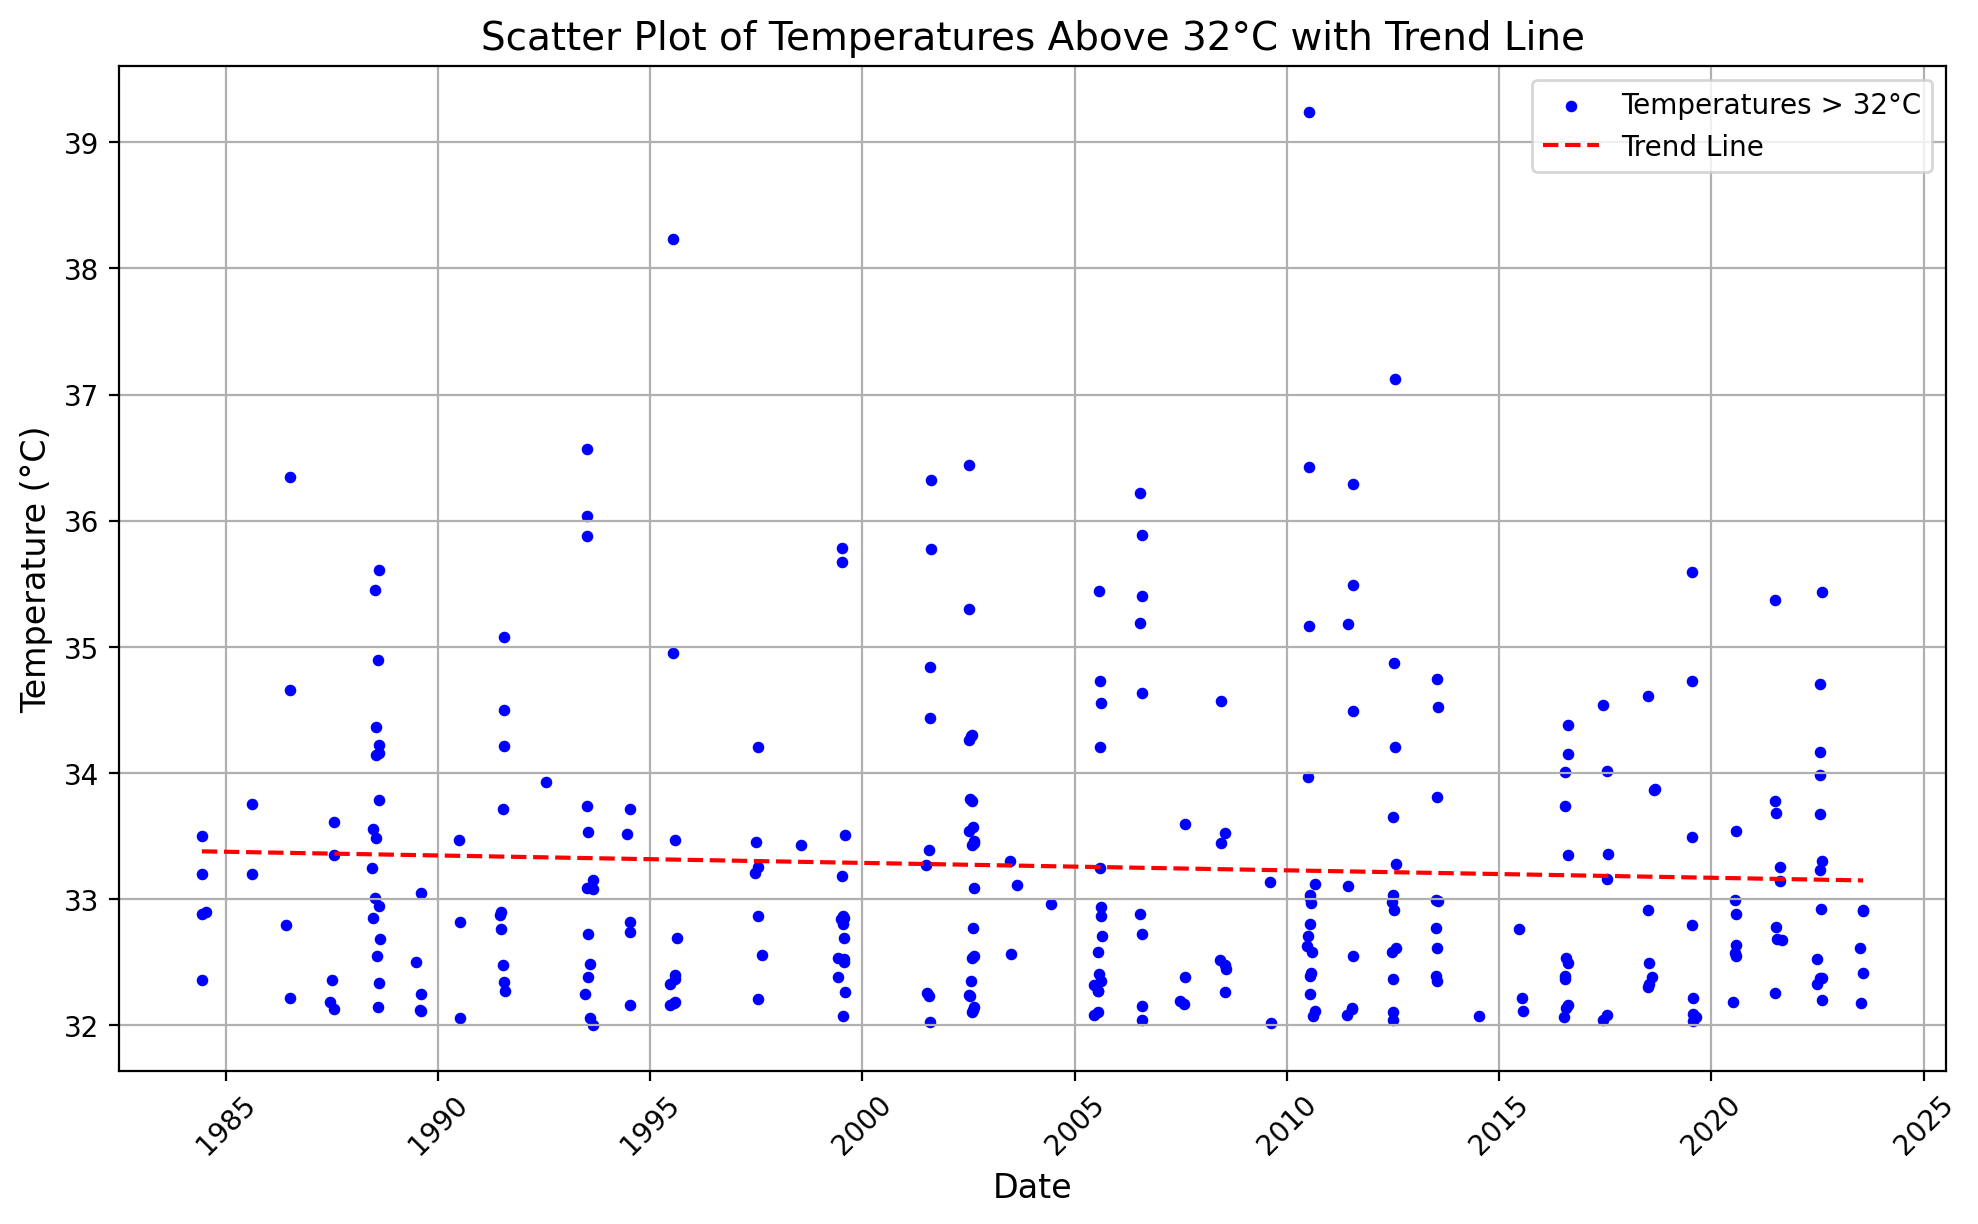

In [6]:
daily_max_temp_path = '/home/jovyan/rces-assignments/Project/final/daily_max.nc'
daily_max_temp = xr.open_dataset(daily_max_temp_path) - 273.15

threshold = 32
high_temp_data = daily_max_temp['t2m'][daily_max_temp['t2m'] >= threshold]

# 3. 获取日期和对应的温度数据
dates = high_temp_data['time'].values
temperatures = high_temp_data.values

# 4. 将日期转化为数字（计算日期与起始日期的天数差）
# 假设从数据的第一个日期开始计算天数差
base_date = np.datetime64('1970-01-01')
dates_num = (dates - base_date).astype('timedelta64[D]').astype(int)  # 转换为天数

# 5. 使用线性回归拟合趋势线
model = LinearRegression()
model.fit(dates_num.reshape(-1, 1), temperatures)

# 6. 预测趋势线
trend_line = model.predict(dates_num.reshape(-1, 1))

# 7. 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(dates, temperatures, color='blue', s=10, label='Temperatures > 32°C')

# 8. 绘制趋势线
plt.plot(dates, trend_line, color='red', linestyle='--', label='Trend Line')

# 9. 设置图形标签
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Scatter Plot of Temperatures Above 32°C with Trend Line', fontsize=14)
plt.grid(True)

# 10. 展示图形
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend()

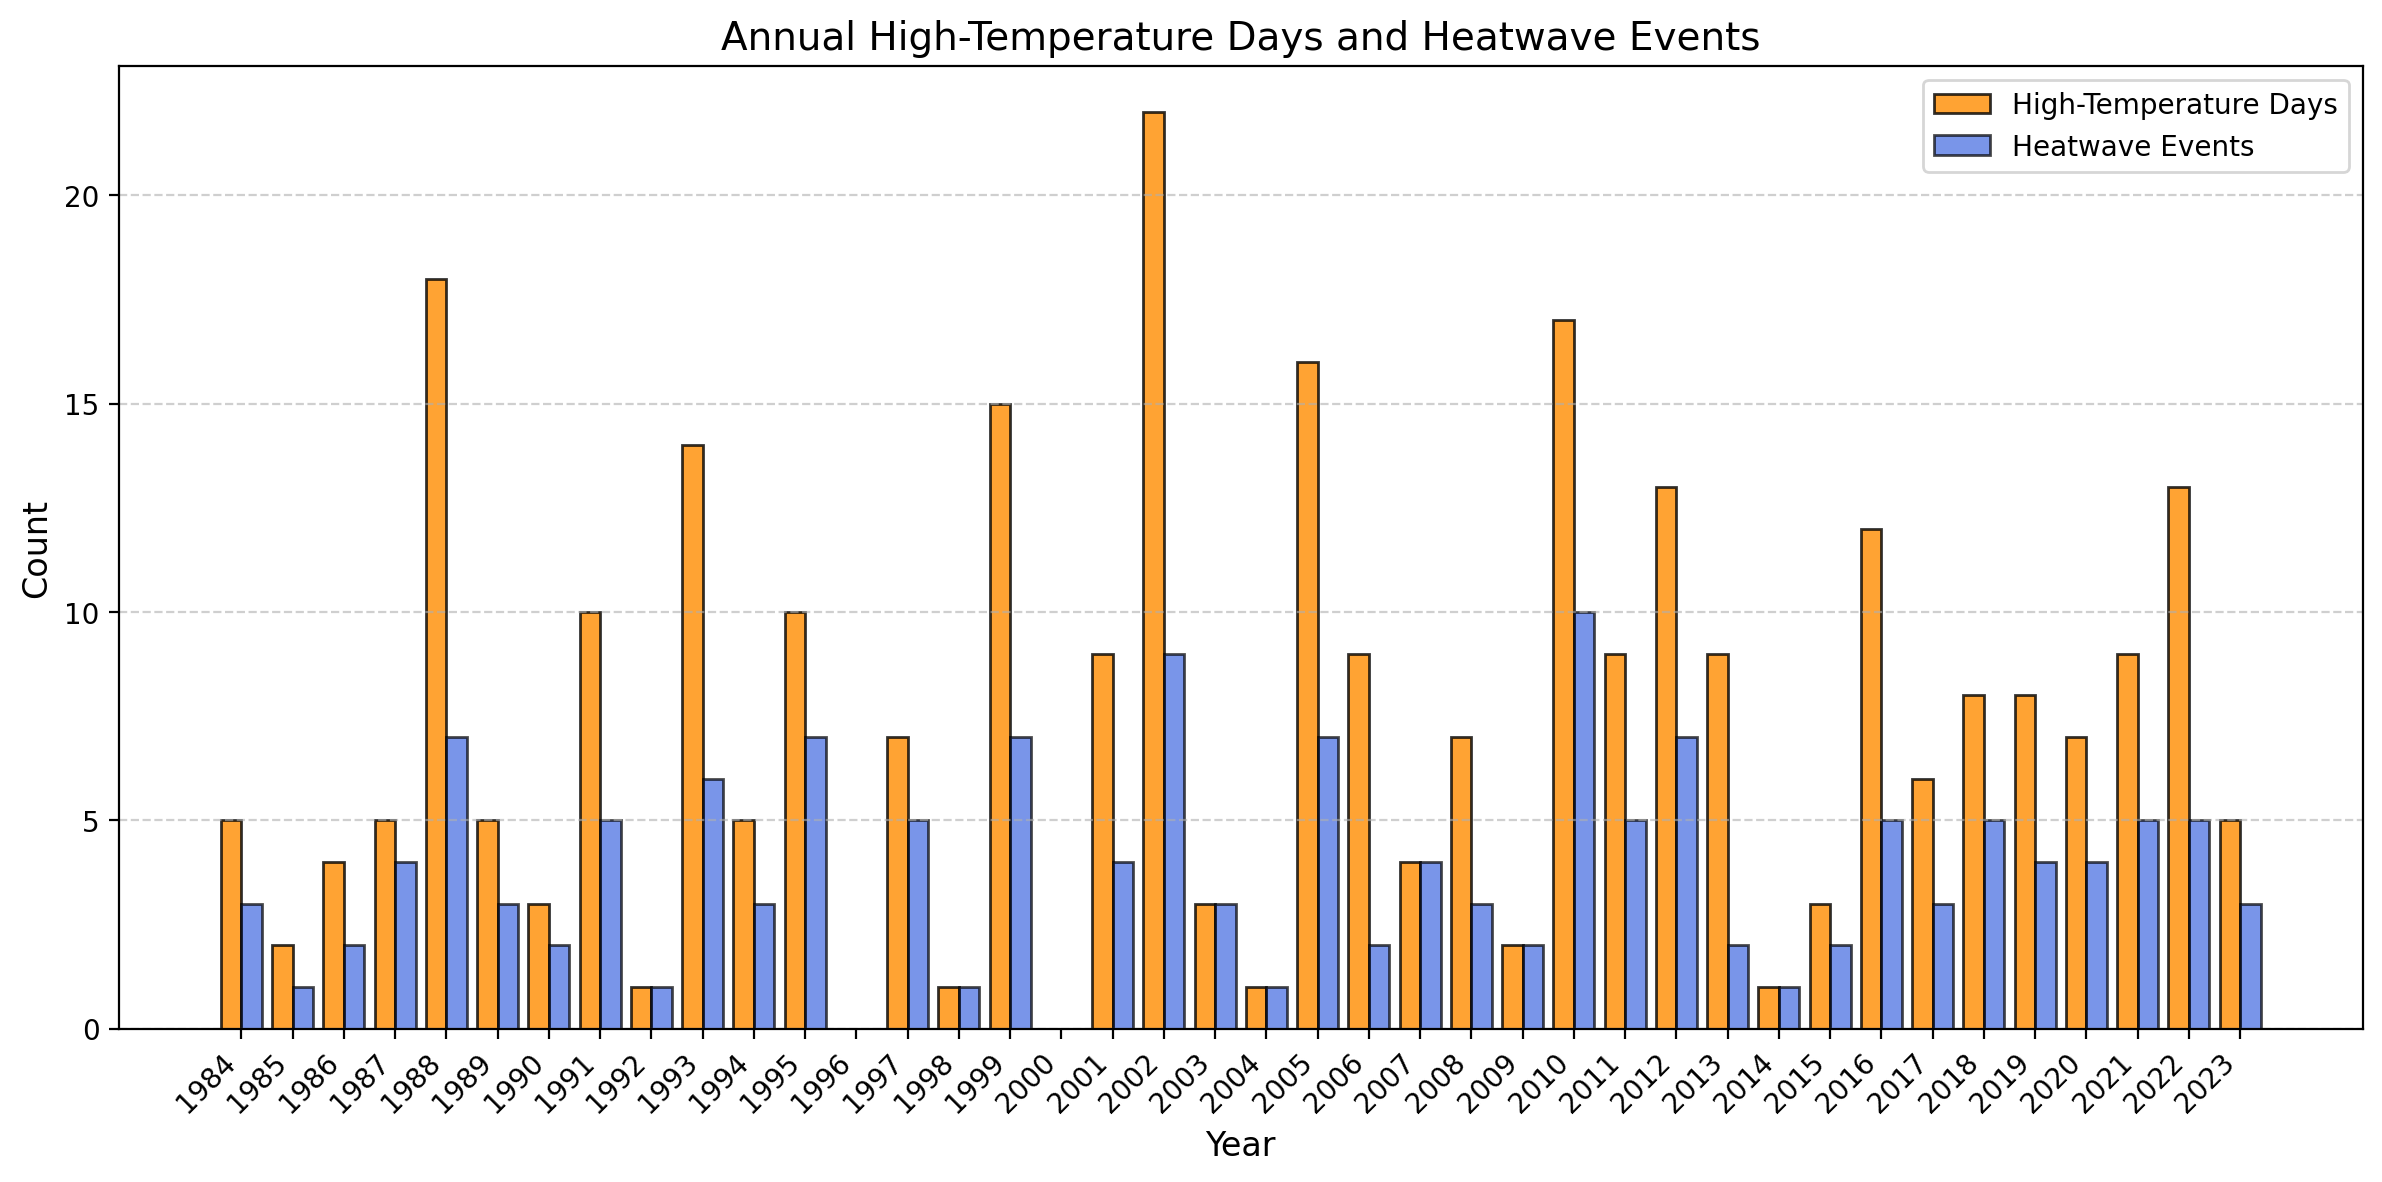

In [9]:
thresholds_per_year = 32
high_temp_days = (daily_max_temp['t2m'] >= thresholds_per_year).astype(int)

rolling_sum = high_temp_days.rolling(time=2).sum()  
heatwave_events = (rolling_sum >= 2).astype(int)    

heatwave_events = np.zeros_like(high_temp_days.values)

current_event = 0  
for i in range(len(high_temp_days)):
    if high_temp_days.values[i] == 1: 
        if i == 0 or high_temp_days.values[i - 1] == 0:  
            current_event += 1  
        heatwave_events[i] = current_event  
    else:
        heatwave_events[i] = 0  
        
heatwave_events_xr = xr.DataArray(
    heatwave_events,
    coords={'time': daily_max_temp['time'], 
            'year': daily_max_temp['time.year']},  
    dims=['time'],  
    name='heatwave_events'
)


def count_unique_events(x):
    return xr.DataArray(
        len(np.unique(x.values[x.values > 0])),
        coords={'year': [int(x['year'].values[0])]},  
        dims=['year'] 
    )


unique_heatwaves_per_year = heatwave_events_xr.groupby("year").apply(count_unique_events)


heatwave_counts = unique_heatwaves_per_year.values
years = unique_heatwaves_per_year.coords["year"].values

high_temp_days_per_year = high_temp_days.groupby("time.year").sum()
high_temp_days_counts = high_temp_days_per_year.values 

bar_width = 0.4

# 创建图形
plt.figure(figsize=(12, 6))

# 创建x轴的位置
index = np.arange(len(years))

# 绘制高温天数柱状图
plt.bar(index - bar_width/2, high_temp_days_counts, bar_width, 
        color="darkorange", edgecolor="black", alpha=0.8, 
        label="High-Temperature Days")

# 绘制热浪事件柱状图
plt.bar(index + bar_width/2, heatwave_counts, bar_width, 
        color="royalblue", edgecolor="black", alpha=0.7, 
        label="Heatwave Events")

# 设置x轴刻度
plt.xticks(index, years, rotation=45, ha='right')

# 设置标签和标题
plt.xlabel("Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Annual High-Temperature Days and Heatwave Events", fontsize=14)

# 添加图例
plt.legend()

# 添加网格线
plt.grid(axis="y", linestyle="--", alpha=0.6)

# 调整布局
plt.tight_layout()

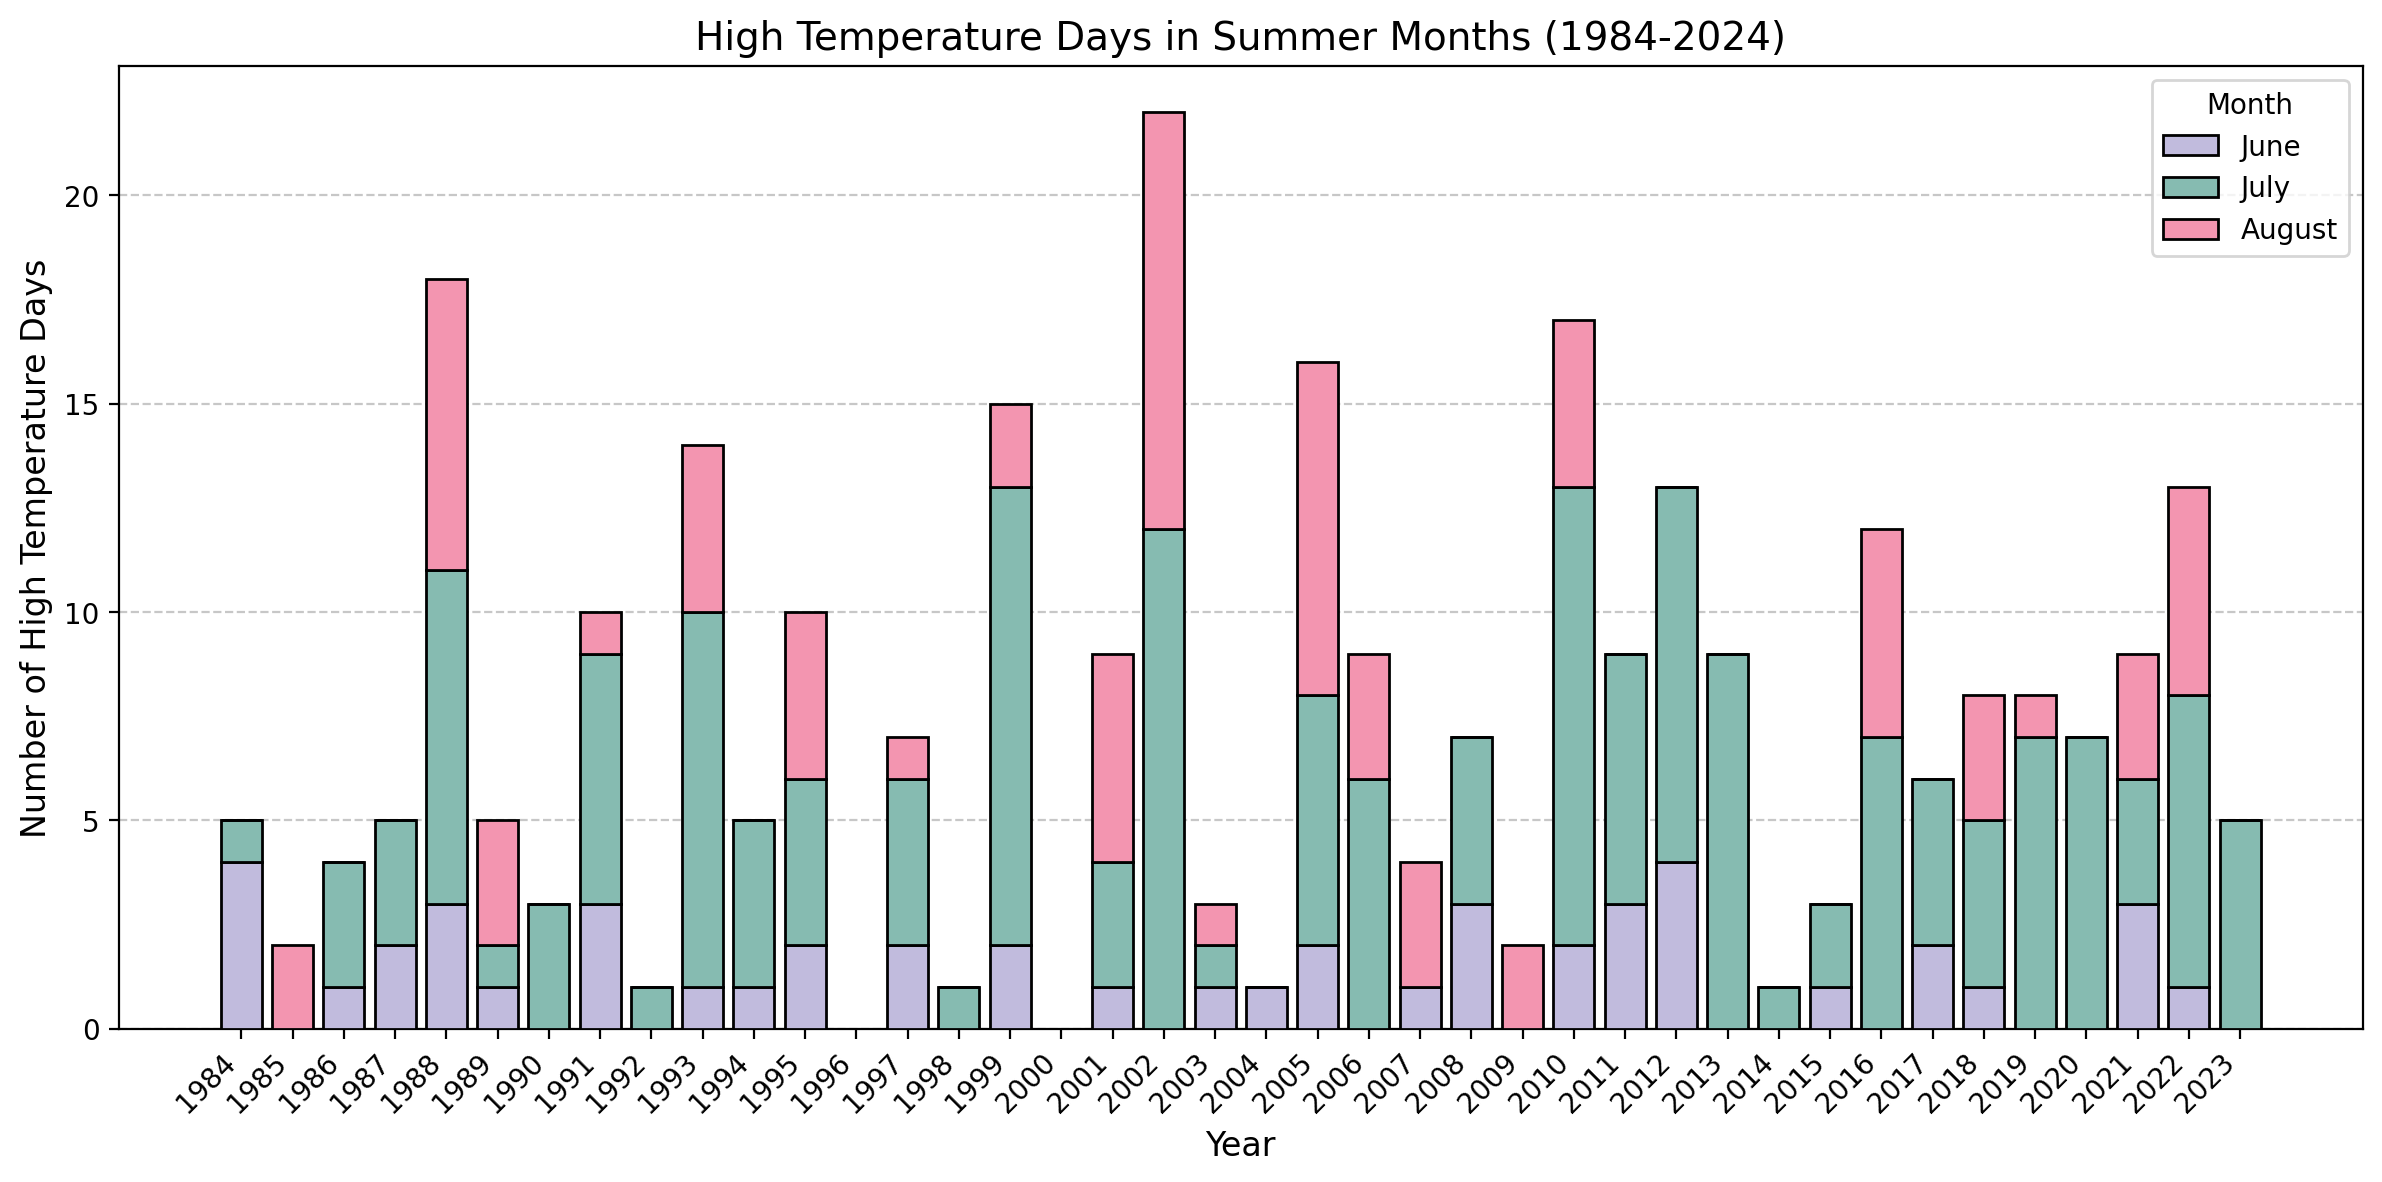

In [10]:
summer_months = [6, 7, 8]
summer_high_temp_days = high_temp_days.sel(time=high_temp_days['time.month'].isin(summer_months))

# Group by year and month, then sum
monthly_summer_high_temp_days = summer_high_temp_days.groupby("time.year").sum()

# Prepare data for plotting
years = monthly_summer_high_temp_days['year'].values
june_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 6).groupby("time.year").sum()
july_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 7).groupby("time.year").sum()
august_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 8).groupby("time.year").sum()

# Create the plot
plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(years))
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder = 0)
plt.bar(index, june_days, label='June', edgecolor="black", color=(193/255, 187/255, 221/255), zorder = 3)
plt.bar(index, july_days, bottom=june_days, label='July',edgecolor="black", color=(134/255, 187/255, 177/255), zorder = 3)
plt.bar(index, august_days, bottom=june_days+july_days,label='August', edgecolor="black",color=(243/255, 149/255, 176/255), zorder = 3)

plt.title('High Temperature Days in Summer Months (1984-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of High Temperature Days', fontsize=12)
plt.xticks(index, years, rotation=45, ha='right')
plt.legend(title='Month')

plt.tight_layout()

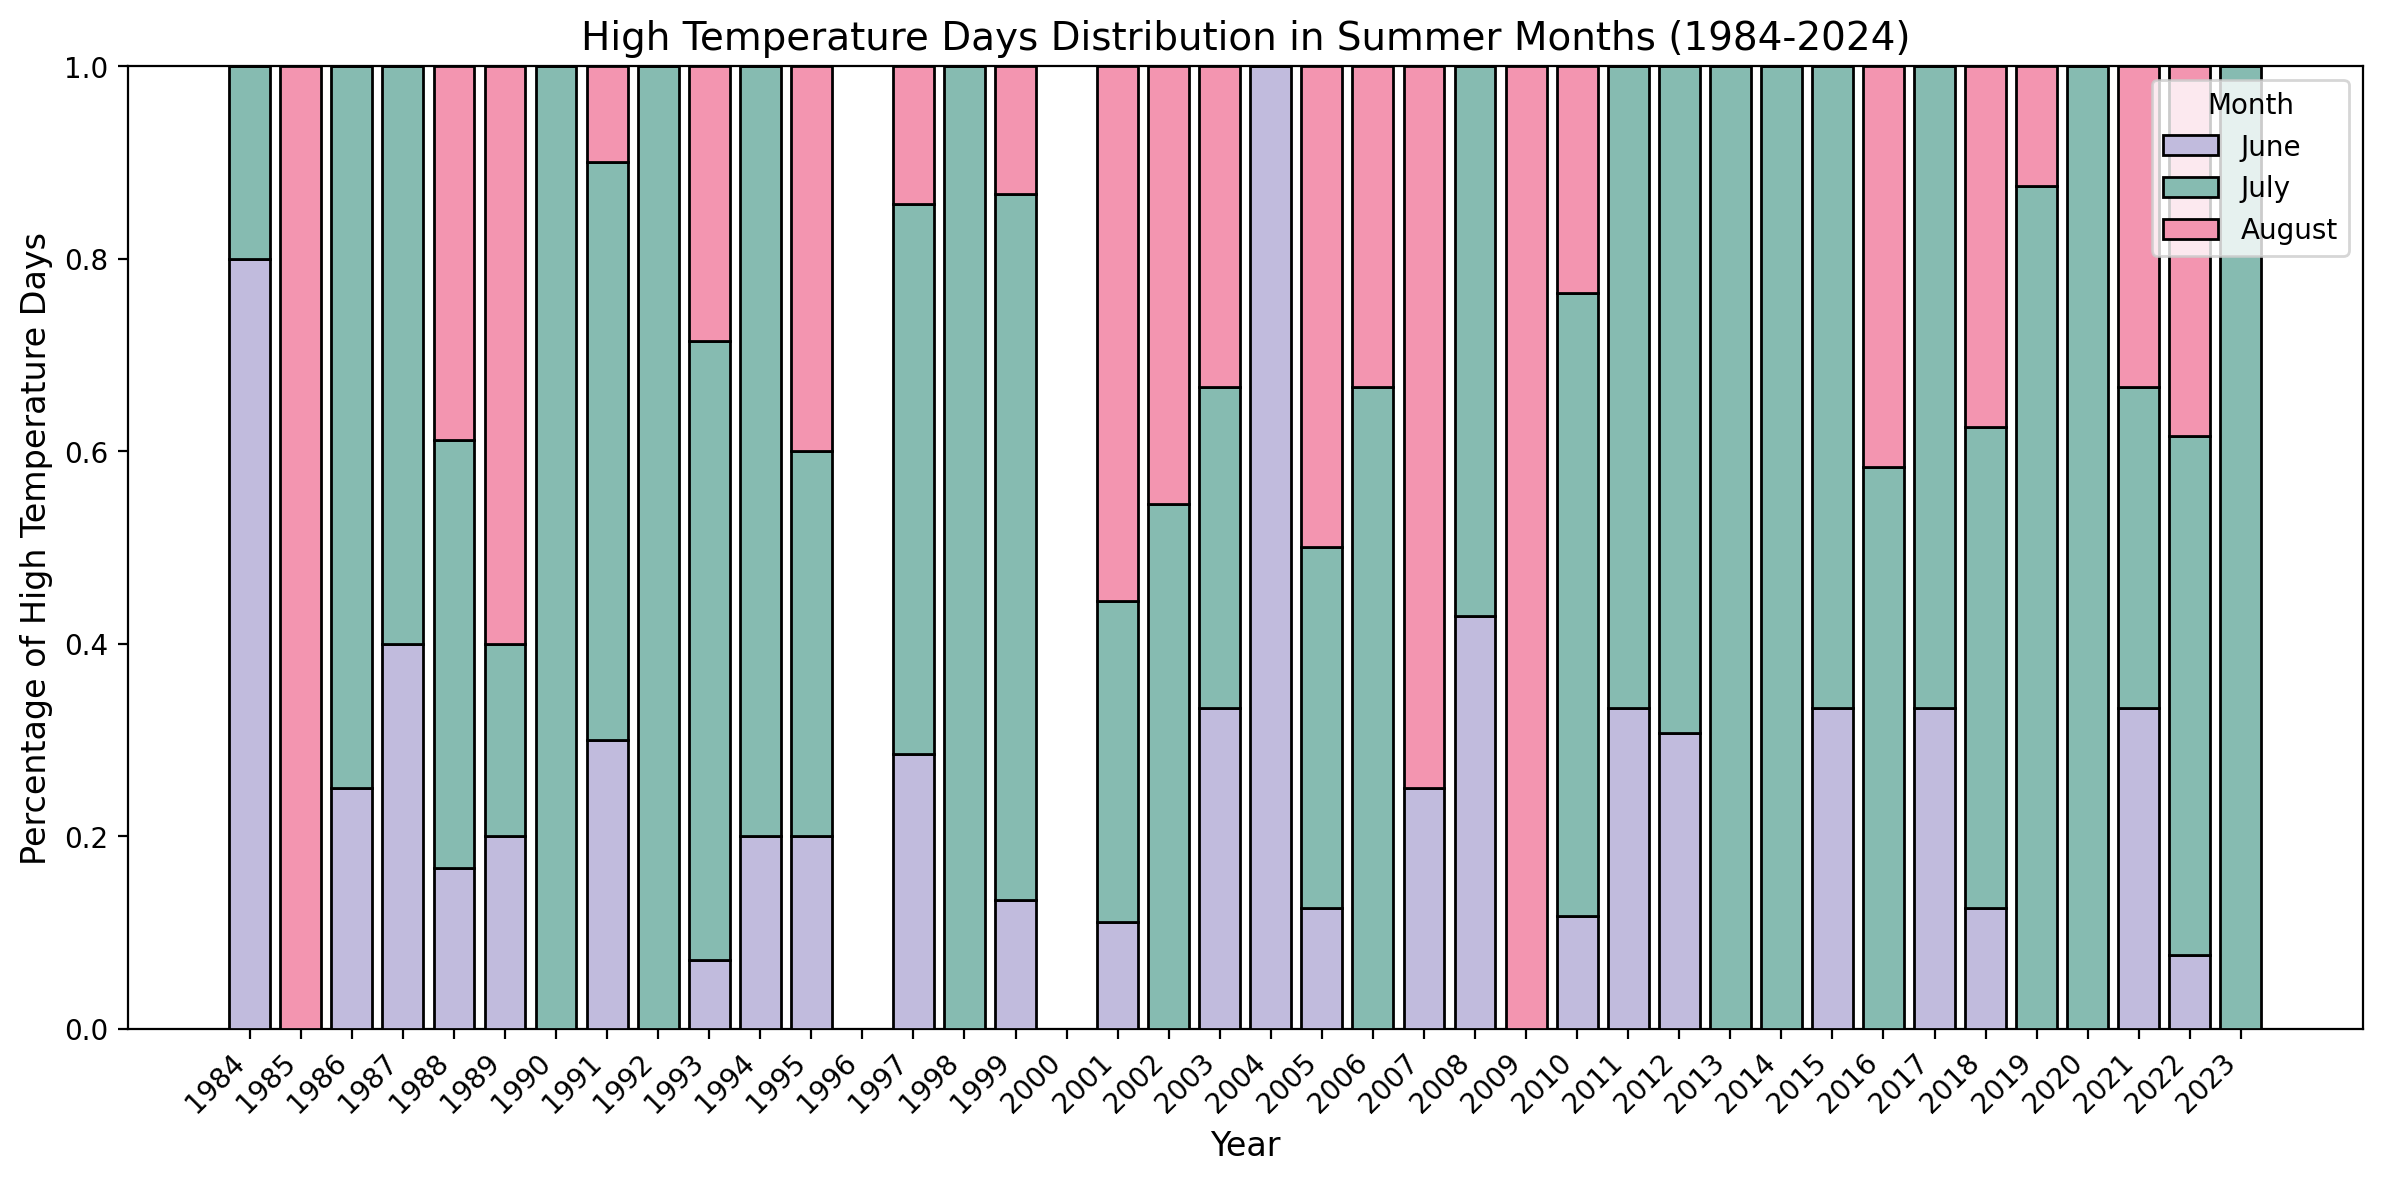

In [11]:
summer_high_temp_days = high_temp_days.sel(time=high_temp_days['time.month'].isin(summer_months))

# Group by year and month, then sum
monthly_summer_high_temp_days = summer_high_temp_days.groupby("time.year").sum()

# Prepare data for plotting
years = monthly_summer_high_temp_days['year'].values
june_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 6).groupby("time.year").sum()
july_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 7).groupby("time.year").sum()
august_days = summer_high_temp_days.sel(time=summer_high_temp_days['time.month'] == 8).groupby("time.year").sum()

june_percent = june_days/monthly_summer_high_temp_days
july_percent = july_days/monthly_summer_high_temp_days
august_percent = august_days/monthly_summer_high_temp_days

plt.bar(index, june_percent, label='June', edgecolor="black", color=(193/255, 187/255, 221/255), zorder = 3)
plt.bar(index, july_percent, bottom=june_percent, label='July',edgecolor="black", color=(134/255, 187/255, 177/255), zorder = 3)
plt.bar(index, august_percent, bottom=june_percent+july_percent,label='August', edgecolor="black",color=(243/255, 149/255, 176/255), zorder = 3)


plt.title('High Temperature Days Distribution in Summer Months (1984-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage of High Temperature Days', fontsize=12)
plt.xticks(index, years, rotation=45, ha='right')
plt.legend(title='Month')

plt.tight_layout()

In [14]:
#high temp consecutive
def calculate_consecutive_high_temps(daily_max_temp, threshold=32):
    """
    计算指定四年的持续高温天数（高温天定义为连续两天以上的气温超过指定阈值）。

    参数：
    - daily_max_temp: xarray.Dataset，表示每日最高温度的时间序列数据。
    - threshold: float，定义高温的阈值（摄氏度）。

    返回：
    - dict，包含指定四年的持续高温天数。
    """
    # 指定需要计算的年份
    years_to_calculate = [1988, 2002, 2010, 2022]
    yearly_results = {}

    for year in years_to_calculate:
        # 提取当年的数据
        yearly_data = daily_max_temp['t2m'].sel(time=daily_max_temp['time.year'] == year)
        
        # 标记高温天（1表示高温，0表示非高温）
        high_temp_flags = (yearly_data >= threshold).astype(int)
        
        # 检测连续段落变化
        diff = high_temp_flags.diff(dim='time', label='lower').fillna(0)  # 填补第一天的 NaN
        consecutive_days = (diff != 0).cumsum(dim='time')
        
        # 修复 `.diff()` 丢失的第一个时间点
        consecutive_days = consecutive_days.pad({'time': (1, 0)}, constant_values=0)
        
        # 确保维度对齐
        consecutive_days = consecutive_days.assign_coords(time=high_temp_flags['time'])
        
        # 统计每段连续高温的天数
        group_counts = high_temp_flags.groupby(consecutive_days).sum(dim='time')
        
        # 仅保留持续两天以上的高温段落
        total_consecutive_high_temps = group_counts.where(group_counts > 1).sum().item()
        
        # 保存结果
        yearly_results[year] = total_consecutive_high_temps
        
        # 分别输出每年的结果
        print(f"Year: {year}, Consecutive High-Temp Days: {total_consecutive_high_temps}")

    # 返回结果为字典
    return yearly_results

# 调用函数
result = calculate_consecutive_high_temps(daily_max_temp)
print(f"\nFinal Result:\n{result}")

Year: 1988, Consecutive High-Temp Days: 16.0
Year: 2002, Consecutive High-Temp Days: 18.0
Year: 2010, Consecutive High-Temp Days: 10.0
Year: 2022, Consecutive High-Temp Days: 11.0

Final Result:
{1988: 16.0, 2002: 18.0, 2010: 10.0, 2022: 11.0}


In [15]:
#extreme temp consecutive
def calculate_consecutive_high_temps(daily_max_temp, threshold=35):
    """
    计算指定四年的持续高温天数（高温天定义为连续两天以上的气温超过指定阈值）。

    参数：
    - daily_max_temp: xarray.Dataset，表示每日最高温度的时间序列数据。
    - threshold: float，定义高温的阈值（摄氏度）。

    返回：
    - dict，包含指定四年的持续高温天数。
    """
    # 指定需要计算的年份
    years_to_calculate = [1988, 2002, 2010, 2022]
    yearly_results = {}

    for year in years_to_calculate:
        # 提取当年的数据
        yearly_data = daily_max_temp['t2m'].sel(time=daily_max_temp['time.year'] == year)
        
        # 标记高温天（1表示高温，0表示非高温）
        high_temp_flags = (yearly_data >= threshold).astype(int)
        
        # 检测连续段落变化
        diff = high_temp_flags.diff(dim='time', label='lower').fillna(0)  # 填补第一天的 NaN
        consecutive_days = (diff != 0).cumsum(dim='time')
        
        # 修复 `.diff()` 丢失的第一个时间点
        consecutive_days = consecutive_days.pad({'time': (1, 0)}, constant_values=0)
        
        # 确保维度对齐
        consecutive_days = consecutive_days.assign_coords(time=high_temp_flags['time'])
        
        # 统计每段连续高温的天数
        group_counts = high_temp_flags.groupby(consecutive_days).sum(dim='time')
        
        # 仅保留持续两天以上的高温段落
        total_consecutive_high_temps = group_counts.where(group_counts > 1).sum().item()
        
        # 保存结果
        yearly_results[year] = total_consecutive_high_temps
        
        # 分别输出每年的结果
        print(f"Year: {year}, Consecutive High-Temp Days: {total_consecutive_high_temps}")

    # 返回结果为字典
    return yearly_results

# 调用函数
result = calculate_consecutive_high_temps(daily_max_temp)
print(f"\nFinal Result:\n{result}")

Year: 1988, Consecutive High-Temp Days: 0.0
Year: 2002, Consecutive High-Temp Days: 2.0
Year: 2010, Consecutive High-Temp Days: 3.0
Year: 2022, Consecutive High-Temp Days: 0.0

Final Result:
{1988: 0.0, 2002: 2.0, 2010: 3.0, 2022: 0.0}


In [18]:
#extreme temp days

thresholds_extreme = 35
extreme_temp_days = (daily_max_temp['t2m'] >= thresholds_extreme).astype(int)
extreme_temp_days_per_year = extreme_temp_days.groupby("time.year").sum()

years = extreme_temp_days_per_year["year"].values 
extreme_temp_days_counts = extreme_temp_days_per_year.values 
selected_years = [1988, 2002, 2010, 2022]
selected_counts = {
    year: extreme_temp_days_per_year.sel(year=year).item()
    for year in selected_years
}

# 输出结果
for year, count in selected_counts.items():
    print(f"Year: {year}, Extreme Heat Days: {count}")

Year: 1988, Extreme Heat Days: 2
Year: 2002, Extreme Heat Days: 2
Year: 2010, Extreme Heat Days: 3
Year: 2022, Extreme Heat Days: 1


In [19]:
#extreme temp

max_values_per_year = {}

# 遍历选定年份并计算最大值
for year in selected_years:
    # 筛选当前年份的数据
    yearly_data = daily_max_temp['t2m'].sel(time=daily_max_temp['time.year'] == year)
    # 计算该年份的最大值
    max_temp = yearly_data.max().values
    # 存储结果
    max_values_per_year[year] = max_temp

# 输出结果
for year, max_temp in max_values_per_year.items():
    print(f"Year: {year}, Max Daily Temperature: {max_temp:.2f}°C")

Year: 1988, Max Daily Temperature: 35.61°C
Year: 2002, Max Daily Temperature: 36.44°C
Year: 2010, Max Daily Temperature: 39.24°C
Year: 2022, Max Daily Temperature: 35.43°C


In [20]:
#high temp days
thresholds_per_year = 32
high_temp_days = (daily_max_temp['t2m'] >= thresholds_per_year).astype(int)
high_temp_days_per_year = high_temp_days.groupby("time.year").sum()

years = extreme_temp_days_per_year["year"].values 
high_temp_days_counts = high_temp_days_per_year.values 
selected_years = [1988, 2002, 2010, 2022]
selected_counts = {
    year: high_temp_days_per_year.sel(year=year).item()
    for year in selected_years
}

# 输出结果
for year, count in selected_counts.items():
    print(f"Year: {year}, high Heat Days: {count}")

Year: 1988, high Heat Days: 18
Year: 2002, high Heat Days: 22
Year: 2010, high Heat Days: 17
Year: 2022, high Heat Days: 13


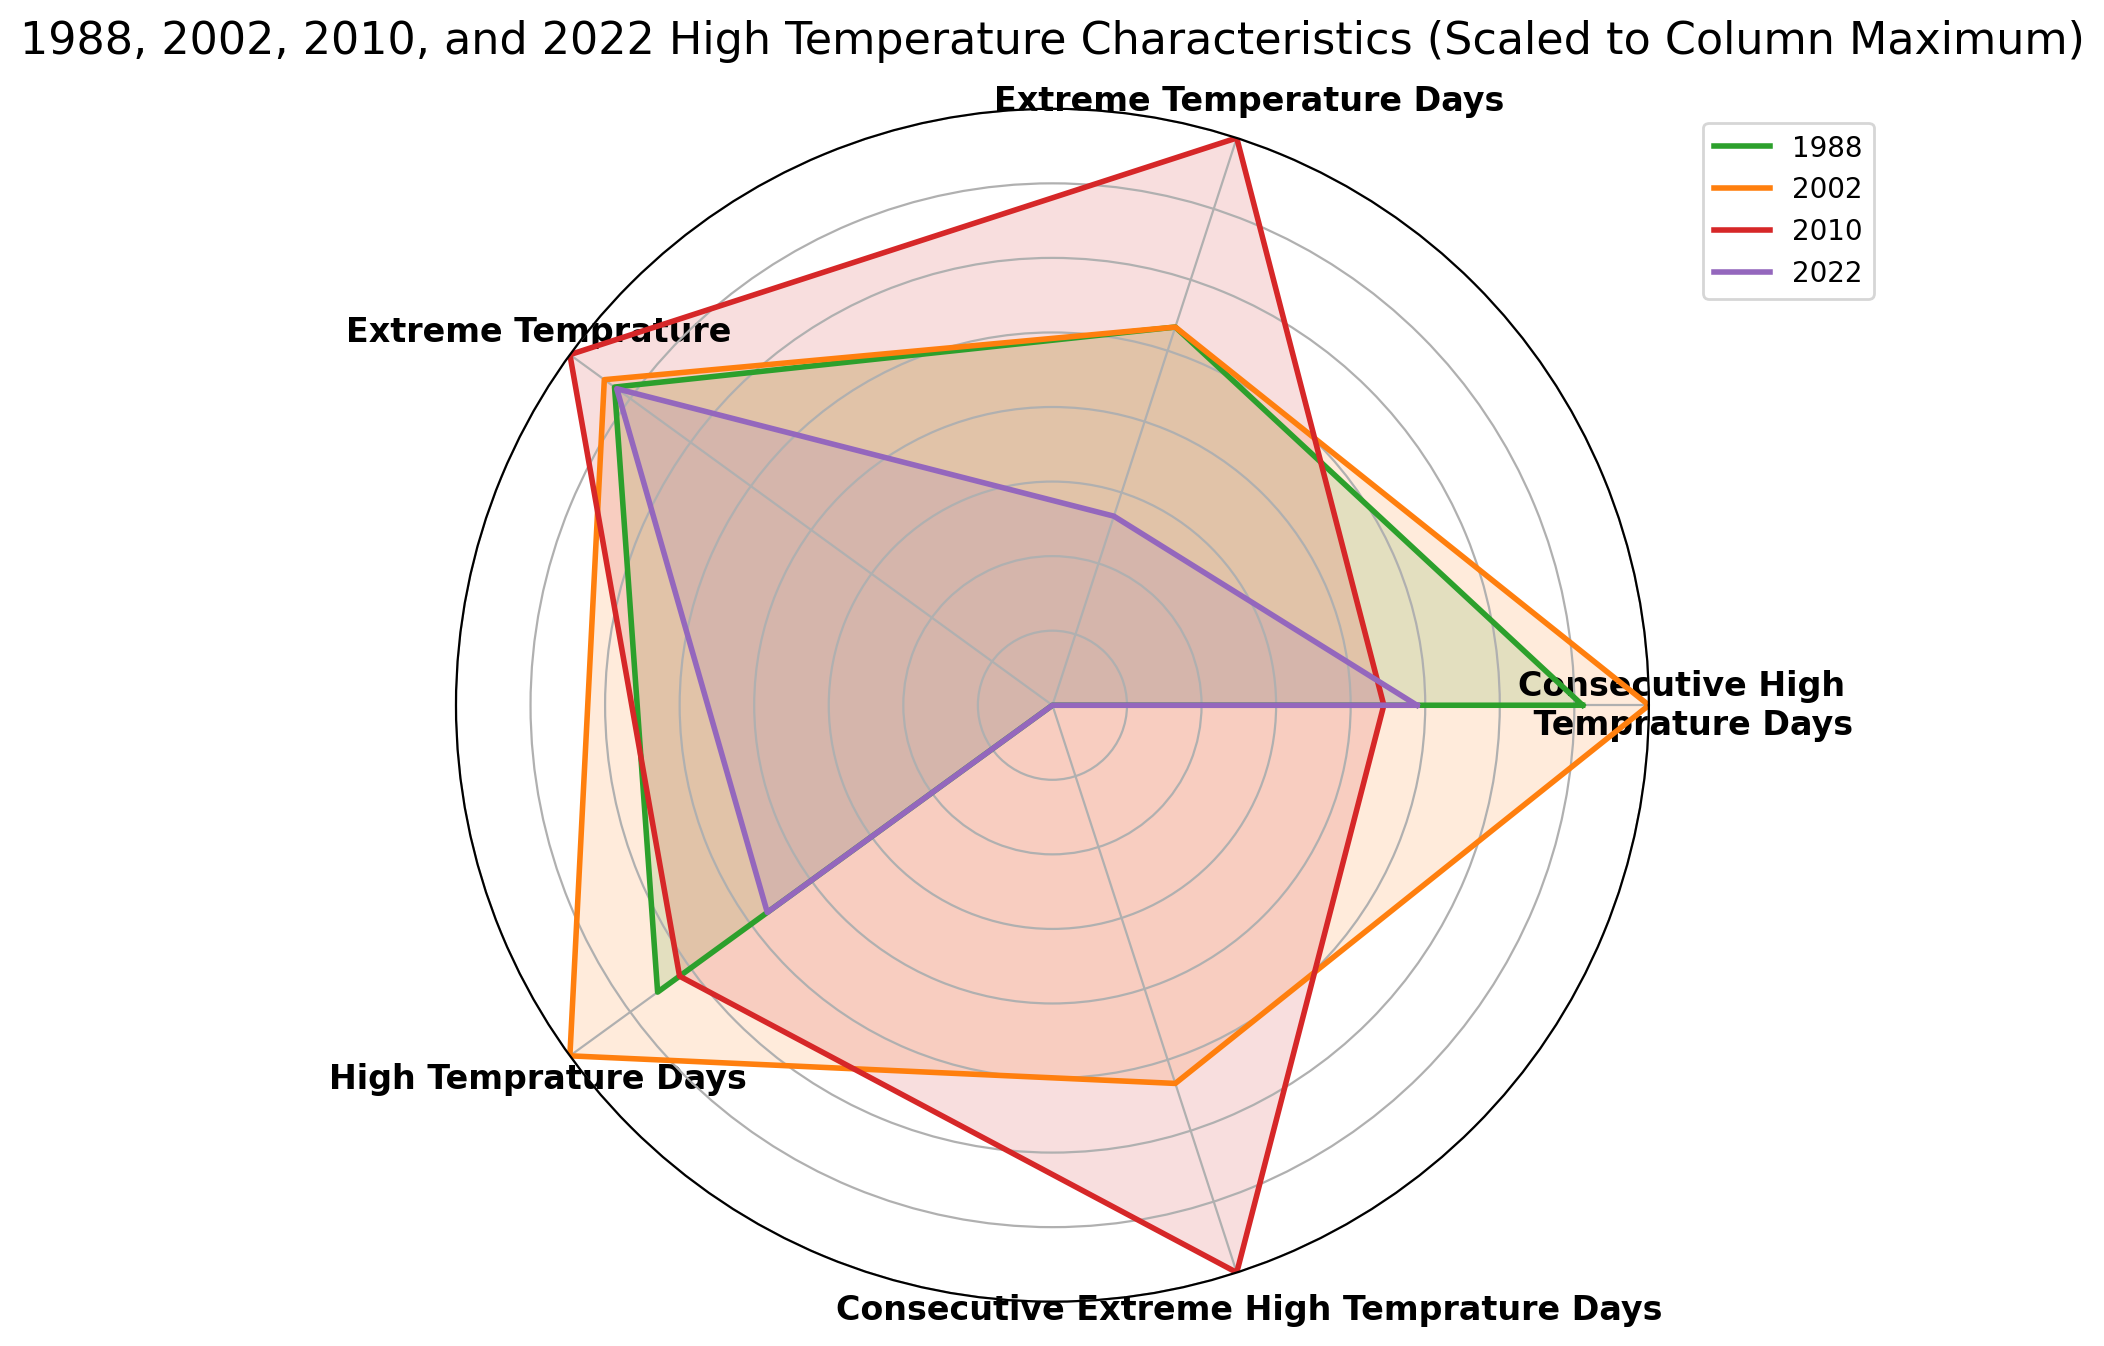

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 定义数据和标签
labels = ['Consecutive High \n Temprature Days', 'Extreme Temperature Days', 'Extreme Temprature', 'High Temprature Days', 'Consecutive Extreme High Temprature Days']
data_1988 = [16.0, 2, 35.61, 18, 0.0]
data_2002 = [18.0, 2, 36.44, 22, 2.0]
data_2010 = [10.0, 3, 39.24, 17, 3.0]
data_2022 = [11.0, 1, 35.43, 13, 0.0]

# 将所有数据放入一个矩阵中，便于逐列计算最大值
data_matrix = np.array([data_1988, data_2002, data_2010, data_2022])

# 2. 计算每列的最大值
max_values = np.max(data_matrix, axis=0)

# 3. 对每年的数据进行缩放
scaled_data_1988 = (np.array(data_1988) / max_values) * 40
scaled_data_2002 = (np.array(data_2002) / max_values) * 40
scaled_data_2010 = (np.array(data_2010) / max_values) * 40
scaled_data_2022 = (np.array(data_2022) / max_values) * 40

# 4. 计算每个顶点的角度（五边形均匀分布）
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# 5. 添加第一个点到末尾，使得图形闭合
scaled_data_1988 = np.concatenate((scaled_data_1988, [scaled_data_1988[0]]))
scaled_data_2002 = np.concatenate((scaled_data_2002, [scaled_data_2002[0]]))
scaled_data_2010 = np.concatenate((scaled_data_2010, [scaled_data_2010[0]]))
scaled_data_2022 = np.concatenate((scaled_data_2022, [scaled_data_2022[0]]))
angles += angles[:1]

# 6. 创建图形
fig, ax = plt.subplots(figsize=(8, 8), dpi=100, subplot_kw=dict(polar=True))

# 7. 绘制每个年份的数据（使用比例缩放后的数据）
ax.plot(angles, scaled_data_1988, color='#2CA02C', linewidth=2, label='1988')
ax.plot(angles, scaled_data_2002, color='#FF7F0E', linewidth=2, label='2002')
ax.plot(angles, scaled_data_2010, color='#D62728', linewidth=2, label='2010')
ax.plot(angles, scaled_data_2022, color='#9467BD', linewidth=2, label='2022')

# 8. 填充区域
ax.fill(angles, scaled_data_1988, color='#2CA02C', alpha=0.15)
ax.fill(angles, scaled_data_2002, color='#FF7F0E', alpha=0.15)
ax.fill(angles, scaled_data_2010, color='#D62728', alpha=0.15)
ax.fill(angles, scaled_data_2022, color='#9467BD', alpha=0.15)

# 9. 设置标签
ax.set_yticklabels([])  # 隐藏半径标签
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')

# 10. 设置统一的最大值为 40
ax.set_ylim(0, 40)


# 11. 图例
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# 12. 调整布局并展示
plt.tight_layout()
plt.title("1988, 2002, 2010, and 2022 High Temperature Characteristics (Scaled to Column Maximum)", fontsize=16, pad=20)
plt.show()
